# Diffusion Model met Fashion MNIST in PyTorch

Het doel van dit notebook is om een diffusion model te implementeren dat leert om ruis van afbeeldingen te verwijderen en nieuwe afbeeldingen van mode-items te genereren die vergelijkbaar zijn met de Fashion MNIST dataset.

## Importeren van packages en dataset

In onderstaande code worden de volgende stappen uitgevoerd:
* Laad de Fashion MNIST dataset en normaliseer de afbeeldingen naar het bereik [-1, 1]
* Maak een DataLoader om batches van trainingsgegevens te genereren
* Voeg functies toe om eenvoudiger te kunnen werken met ruis

Data geladen en DataLoader klaar.
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 1, 3, 3, 5, 7, 1, 1])


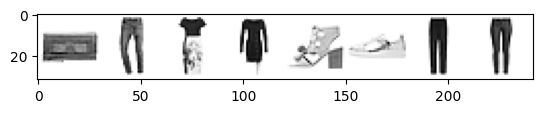

In [1]:
# Importeren van benodigde bibliotheken
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
import os

# Controleer of er een GPU beschikbaar is, zo niet gebruik de CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data-transformatie: normaliseer de afbeeldingen zodat de pixelwaarden tussen -1 en 1 liggen
transform = transforms.Compose([
    transforms.ToTensor(),  # Converteert beeld naar tensor
])

# FashionMNIST dataset downloaden en laden
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader voor batches van de trainingsdata
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

print("Data geladen en DataLoader klaar.")

x, y = next(iter(train_loader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

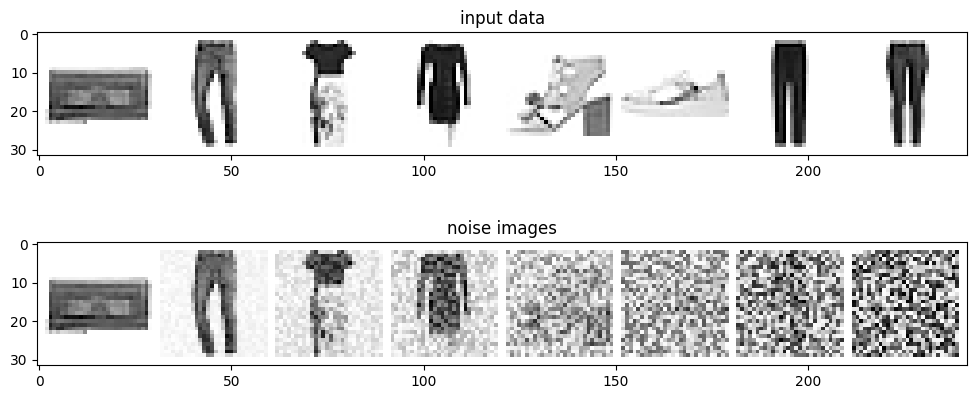

In [4]:
# vereenvoudigde functie om ruis toe te voegen aan een figuur 
def add_noise(img, amount):
    noise = torch.rand_like(img)
    amount = amount.view(-1, 1, 1, 1) # reshape amount so that is is (batch_size, 1, 1, 1)
    return img * (1-amount) + amount * noise

fig, axs = plt.subplots(2, 1, figsize=(12,5))
axs[0].set_title('input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# ruisbeeldjes maken
amount = torch.linspace(0, 1, x.shape[0])
noised_x = add_noise(x, amount)

# teken ruisbeeldjes
axs[1].set_title('noise images')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')


## Bouwen van een model

In deze notebook gaan we werken met een eenvoudig U-Net model dat de taak van ruisvoorspelling uitvoert. Het model bestaat uit encoder-, midden- en decoderlagen. Het model voorspelt de ruis die is toegevoegd aan een afbeelding en probeert deze te verwijderen.
Ook andere modellen kunnen hiervoor gebruikt worden.

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # nu doet het zowel de maxpool als de conv2d omgekeerd
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            # hier willen we typisch iets met een vast bereik, sigmoid (0 en 1), tanh (-1 en 1)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)

        return x

model = UNet()
print(model)

# stuur random data door het model
x = torch.rand(8, 1, 28, 28)
model(x).shape

UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (middle): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Tanh()
  )
)


torch.Size([8, 1, 28, 28])

## Trainen van het model

Om het model te trainen wordt de verliesfunctie MSE-loss en de Adam-optimizer gebruikt. 
Daarnaast berekenen we de betas voor het diffusieproces met behulp van een lineaire verdeling over 1000 timesteps.

Ten slotte wordt het diffusiemodel getraind. Voor elke batch van trainingsafbeeldingen wordt een willekeurige tijdstap gekozen om ruis toe te voegen aan de afbeelding. Het model leert vervolgens de toegevoegde ruis te voorspellen en te verwijderen. Voor elke epoch wordt het verlies uitgeprint.

In [8]:
batch_size=128
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # iets grotere batch size voor performantie

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for n, (images, _) in enumerate(train_loader): # niet geinteresseerd in de labels dus _
        # voeg ruis toe
        noise_amount = torch.rand(images.shape[0])
        noisy_images = add_noise(images, noise_amount)

        # Voorspel de denoised images
        optimizer.zero_grad()
        pred = model(noisy_images)
        loss = criterion(pred, images) # vereenvoudigde versie van het diffusion model (doe ruis in 1 stap naar origineel figuur)

        # pas de gewichten aan
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, loss: {running_loss/len(train_loader)}")

Epoch 0/5, loss: 0.03916819214519026
Epoch 1/5, loss: 0.02588086463669851
Epoch 2/5, loss: 0.02333095308734791
Epoch 3/5, loss: 0.022053996101021767
Epoch 4/5, loss: 0.02105805836816523


## Visualisatie

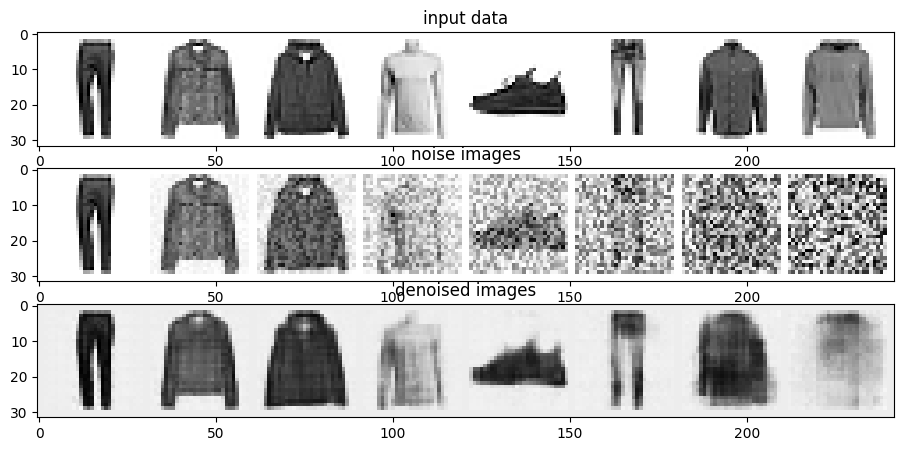

In [10]:
x, y = next(iter(train_loader)) # gebruik 1 batch
x = x[:8] # beperk het tot 8 beeldjes

fig, axs = plt.subplots(3, 1, figsize=(12,5))
axs[0].set_title('input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# ruisbeeldjes maken
amount = torch.linspace(0, 1, x.shape[0])
noised_x = add_noise(x, amount)

# teken ruisbeeldjes
axs[1].set_title('noise images')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')

# denoised images
with torch.no_grad():
    preds = model(noised_x)

axs[2].set_title('denoised images')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')


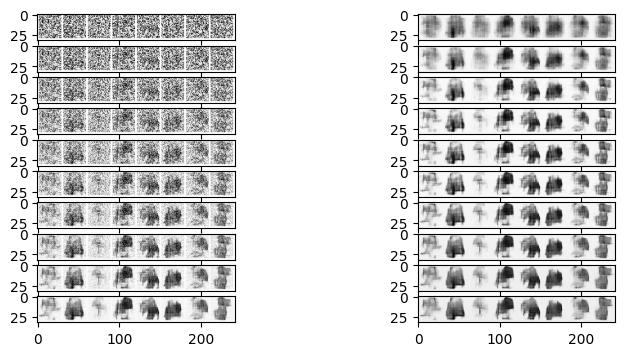

In [12]:
# remove noise in steps for generating new images
n_steps = 10
x= torch.rand(8, 1, 28, 28) # vanaf ruis dus een volledig nieuw beeldje
step_history = [x]
preds_output_history=[]

for i in range(n_steps):
    with torch.no_grad():
        pred = model(x)

    preds_output_history.append(pred)
    mix_factor = 1/(n_steps-i) # omdat we met het vereenvoudig model werken dat direct het origineel beeldje maakt, gaan we maar een stapje in de goede richting gaan
    x = x * (1-mix_factor) + pred * (mix_factor)
    step_history.append(x)

fig, axs = plt.subplots(n_steps, 2, figsize=(9,4), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(preds_output_history[i])[0], cmap='Greys')

### Opmerkingen:

De hierboven gevolgde aanpak is een vereenvoudigde voorstelling van de state-of-the-art diffusion model die wel goed de te volgen concepten uitlegt.
Een meer gedetailleerde uitleg van diffusion models vind je [DDPM paper](https://arxiv.org/abs/2006.11239)
In deze paper breiden ze het voorbeeld in deze notebook uit door:
* Een geavanceerder UNet-model te gebruiken
* Een complexere manier om ruis toe te voegen
* Niet rechtstreeks het begin image te voorspellen maar de ruis in een image te voorspellen
* Gebruik een timestep in plaats van een amount-waarde